#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from simplekml import Kml
from tensorflow.keras.models import load_model
import pickle
from Utils import geo_conversions as gc
%matplotlib widget

In [2]:
#Carga conjunto de Test.
x_test = pd.read_excel("./Train_Test/Dataset_Separado/x_test_new.xlsx")
y_test = pd.read_excel("./Train_Test/Dataset_Separado/y_test_new.xlsx")

# Quita de columnas no usadas en Train 
x_test = x_test.drop(columns=['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [3]:
# Cargamos los modelos.
case = 3	# Puede ser 1, 2 o 3, dependiendo del modelo que se quiera cargar.
  
if case == 1: 
	model_x =  load_model('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/modelo1_x.keras')
	with open('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/scaler_x1.pkl', 'rb') as f:
		scaler_x = pickle.load(f)

	model_y = load_model('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/modelo1_y.keras')
	with open('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/scaler_y1.pkl', 'rb') as f:
		scaler_y = pickle.load(f)
		
	model_z = load_model('./modelos_entrenamiento/mod_z_R0/modelo1/modelo1.keras')
	with open('./modelos_entrenamiento/mod_z_R0/modelo1/scaler_z1.pkl','rb') as f:
		scaler_z = pickle.load(f)

if case == 2: 
    model_z = load_model('./modelos_entrenamiento/mod_z_R0/modelo1/modelo1.keras')
    with open('./modelos_entrenamiento/mod_z_R0/modelo1/scaler_z1.pkl','rb') as f:
        scaler_z = pickle.load(f)

    model_xy = load_model('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/mod_x_y_R0.keras')
    with open('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_x.pkl', 'rb') as f:
        scaler_x = pickle.load(f)
    with open('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_y.pkl', 'rb') as f:
        scaler_y = pickle.load(f)

if case == 3:
      model_xyz = load_model('./modelos_entrenamiento/mod_x_y_z_R0/modelo1/modelo1_xyz.keras')
      with open('./modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_x.pkl', 'rb') as f:
          scaler_x = pickle.load(f)
      with open('./modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_y.pkl', 'rb') as f:
          scaler_y = pickle.load(f)
      with open('./modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_z.pkl', 'rb') as f:
          scaler_z = pickle.load(f)

In [74]:
# Valores verdaderos
idx = 578

R0 = 6.371E6
y_true_x = (y_test.iloc[idx].to_numpy())[0	:100]
y_true_y = (y_test.iloc[idx].to_numpy())[100:200]
y_true_z = (y_test.iloc[idx].to_numpy())[200:300]

# Predicción
if case == 1:
	y_pred_scaled_x = model_x.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
	y_pred_scaled_y = model_y.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
	y_pred_scaled_z = model_z.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
if case  == 2:
	y_pred_scaled_x, y_pred_scaled_y = model_xy.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
	y_pred_scaled_z = model_z.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
if case == 3:
	y_pred_scaled_x, y_pred_scaled_y, y_pred_scaled_z = model_xyz.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

y_pred_x = scaler_x.inverse_transform(y_pred_scaled_x).flatten() * R0
y_pred_y = scaler_y.inverse_transform(y_pred_scaled_y).flatten() * R0
y_pred_z = scaler_z.inverse_transform(y_pred_scaled_z).flatten() * R0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


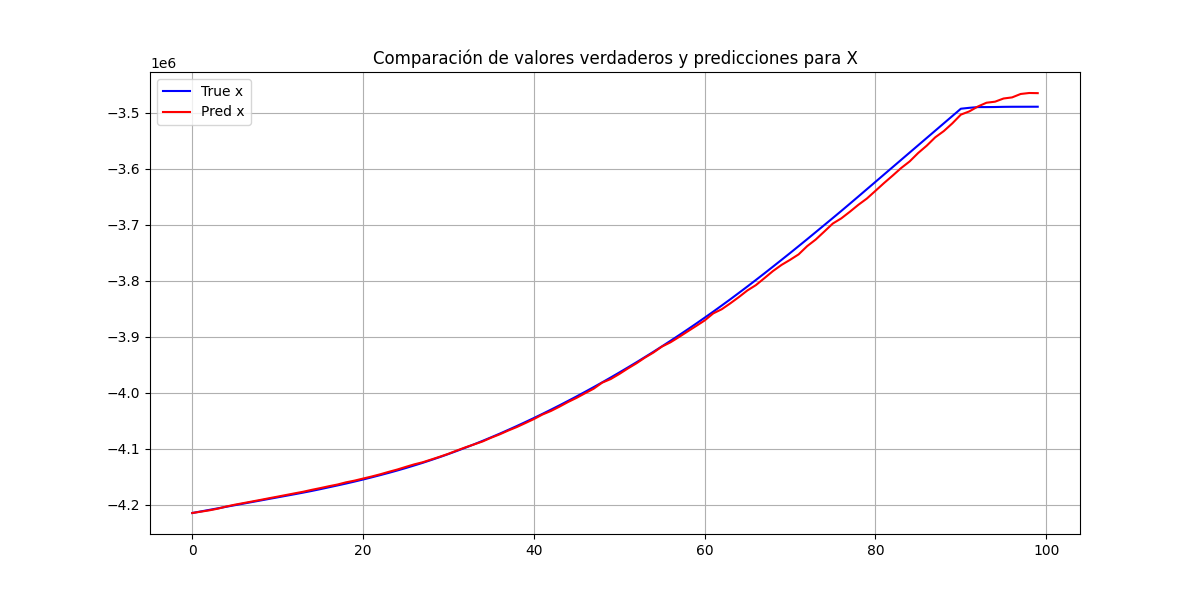

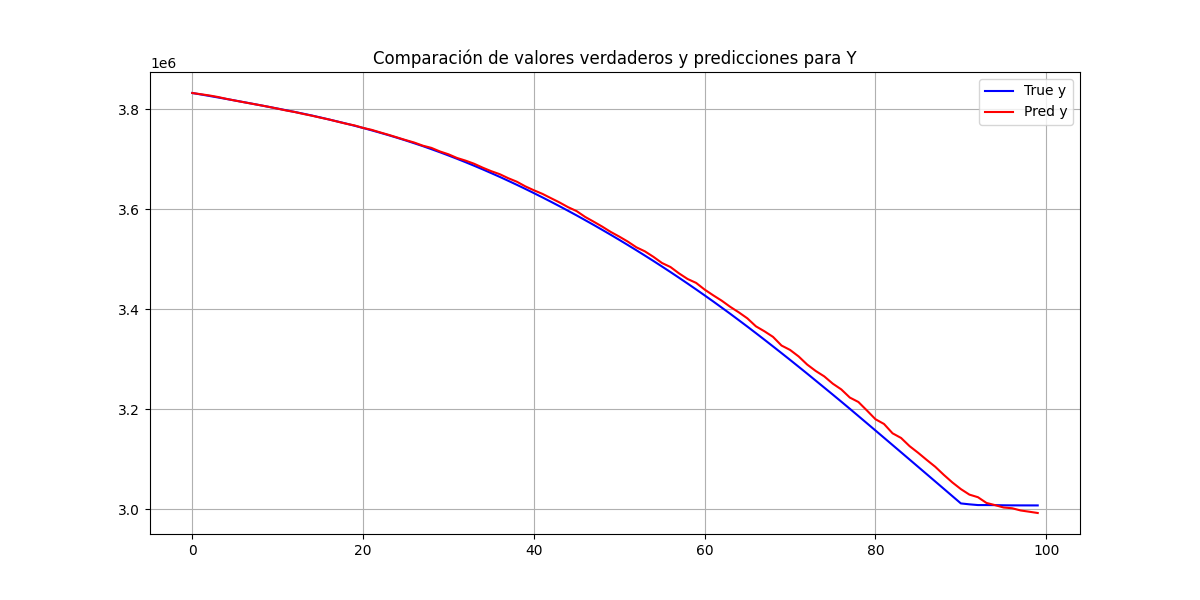

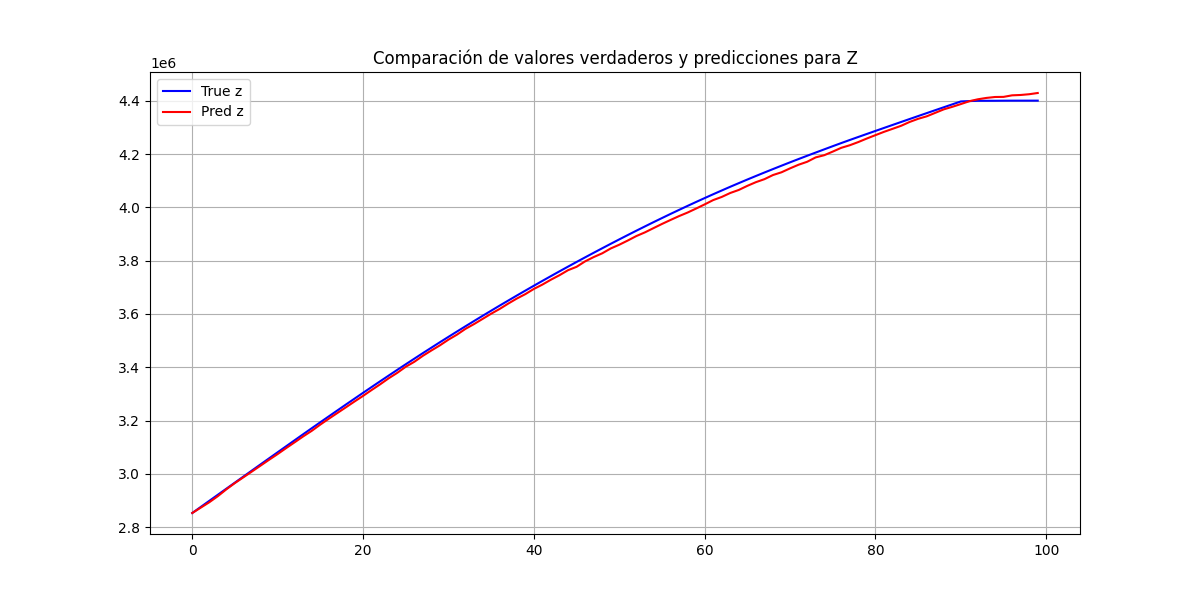

In [75]:
# Graficar resultados
plt.figure(figsize = (12,6))
plt.plot(y_true_x, label = 'True x', color = 'blue')
plt.plot(y_pred_x, label = 'Pred x', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para X')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_y, label = 'True y', color = 'blue')
plt.plot(y_pred_y, label = 'Pred y', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Y')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_z, label = 'True z', color = 'blue')
plt.plot(y_pred_z, label = 'Pred z', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Z')
plt.grid(True)
plt.legend()
plt.show()


In [76]:
#Transformación de coordenadas cartesianas a esféricas y luego a geográficas tanto en test como en predicción.

# phi_true, theta_true, rho_true = gc.transform_cartesian_to_spherical(y_true_x, y_true_y, y_true_z) Anteriormente
lat_true, lon_true, alt_true = gc.transform_spherical_to_geographic(*gc.transform_cartesian_to_spherical(y_true_x, y_true_y, y_true_z))
lat_pred, lon_pred, alt_pred = gc.transform_spherical_to_geographic(*gc.transform_cartesian_to_spherical(y_pred_x, y_pred_y, y_pred_z))

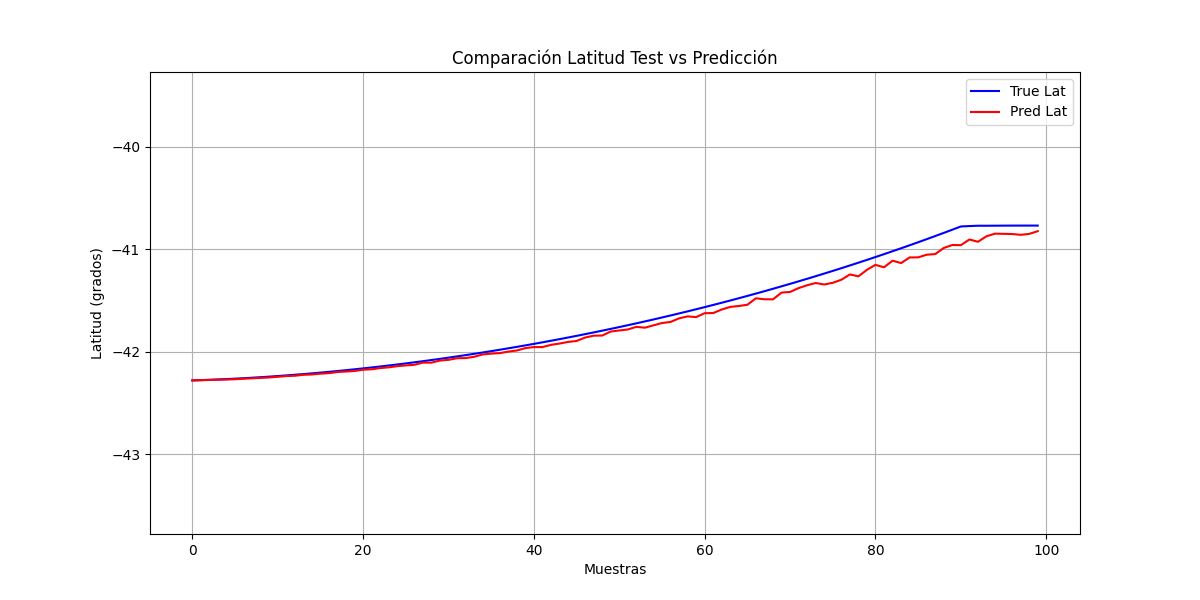

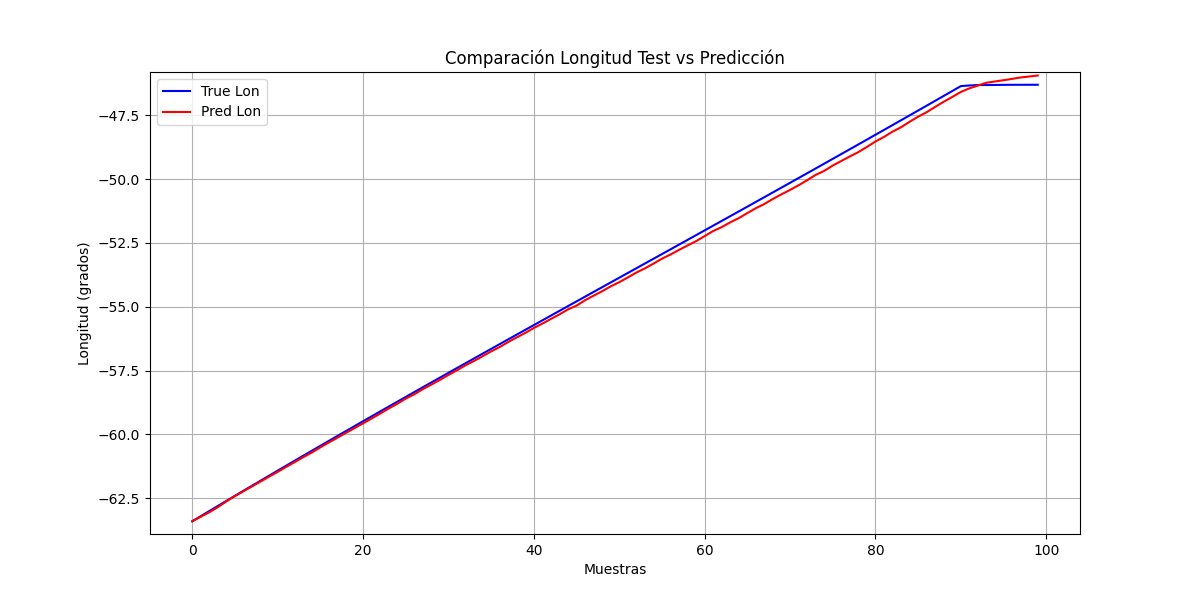

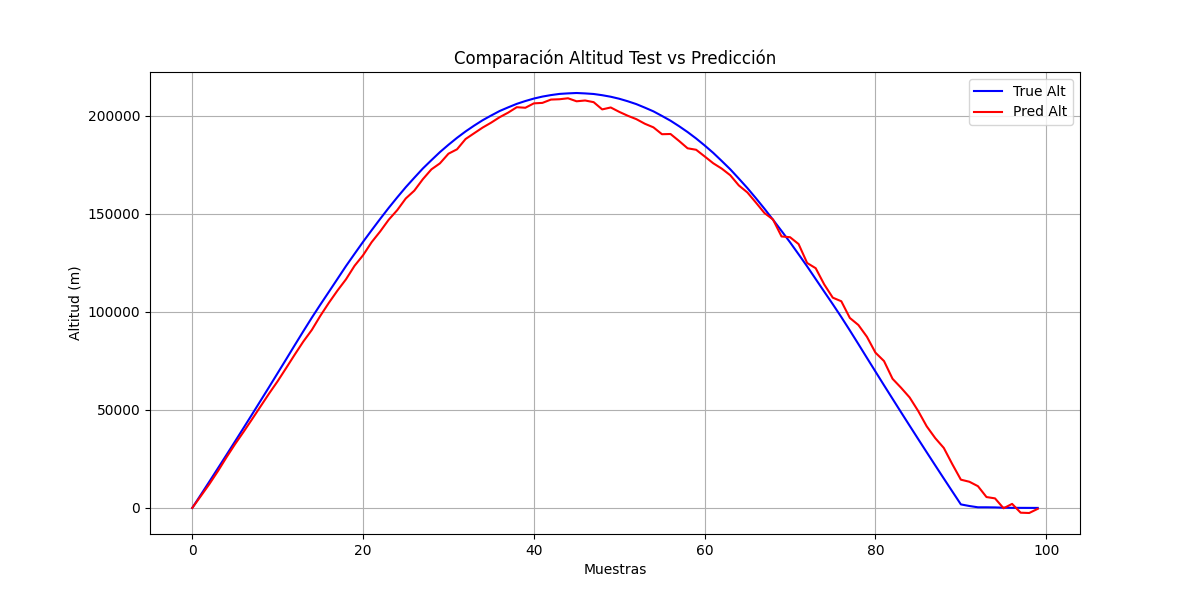

In [77]:
plt.figure(figsize = (12,6))
plt.plot(lat_true, label = 'True Lat', color = 'blue')
plt.plot(lat_pred, label = 'Pred Lat', color = 'red')
plt.ylim(lat_true.min() - 1.5, lat_true.max() + 1.5)
plt.title('Comparación Latitud Test vs Predicción')
plt.ylabel('Latitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize= (12,6))
plt.plot(lon_true, label = 'True Lon', color = 'blue')
plt.plot(lon_pred, label = 'Pred Lon', color = 'red')
plt.ylim(lon_true.min() - 0.5, lon_true.max() + 0.5)
plt.title('Comparación Longitud Test vs Predicción')
plt.ylabel('Longitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (12,6))
plt.plot(alt_true-R0, label = 'True Alt', color = 'blue')
plt.plot(alt_pred-R0, label = 'Pred Alt', color = 'red')
plt.title('Comparación Altitud Test vs Predicción')
plt.ylabel('Altitud (m)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()


In [8]:
print(f'Altura maxima True: {alt_true.max() - R0:.2f} m')
print(f'Altura predicción: {alt_pred.max() - R0:.2f} m')
print(f'Altura minima True: {alt_true.min() - R0:.2f} m')
print(f'Altura predicción: {alt_pred.min() - R0:.2f} m')

Altura maxima True: 214077.50 m
Altura predicción: 208874.00 m
Altura minima True: 0.00 m
Altura predicción: -3963.50 m


In [28]:
# Generamos archivos KML para visualizar en Google Earth	
generar_kml = True
if generar_kml:
  kml = Kml()
  linestring_true = kml.newlinestring(name = "Trayectoria Real")
  linestring_true.coords = list(zip(lon_true, lat_true, alt_true - R0))
  linestring_true.altitudmode = 'absolute'
  linestring_true.extrude = 0
  linestring_true.style.linestyle.width = 5
  linestring_true.style.linestyle.color = 'ff0000ff'  # Rojo
  linestring_pred = kml.newlinestring(name = "Trayectoria Predicha")
  linestring_pred.coords = list(zip(lon_pred, lat_pred, alt_pred - R0))
  linestring_pred.altitudmode = 'absolute'
  linestring_pred.extrude = 0
  linestring_pred.style.linestyle.width = 5
  linestring_pred.style.linestyle.color = 'ff00ff00'  # Verde
  linestring_suav = kml.newlinestring(name = "Trayectoria Suavizada")
  linestring_suav.coords = list(zip(lon,lat, alt)) # no se le resta R0 XQ en el suavizado ya se realizo la resta.
  linestring_suav.altitudmode = 'absolute'
  linestring_suav.extrude = 0
  linestring_suav.style.linestyle.color = 'FFFFB6C1'	# Rosa
  kml.save("trayectoria_test_prediccion_suavizado_muestra_4.kml")
  print("Archivo KML generado: trayectoria_test_prediccion.kml")


Archivo KML generado: trayectoria_test_prediccion.kml


In [29]:
(alt_pred-R0)-alt

array([-2.65975493e-03, -4.15962506e+03, -8.23315911e+03, -1.26298690e+04,
       -1.57859522e+04, -1.77802617e+04, -1.91967218e+04, -2.06540113e+04,
       -2.18440609e+04, -2.31028551e+04, -2.40784438e+04, -2.49816179e+04,
       -2.58142546e+04, -2.64449050e+04, -2.73035501e+04, -2.73581971e+04,
       -2.79748433e+04, -2.79514899e+04, -2.82376363e+04, -2.81362828e+04,
       -2.82234293e+04, -2.83080757e+04, -2.77012222e+04, -2.80758687e+04,
       -2.71965152e+04, -2.65756616e+04, -2.58103081e+04, -2.52799548e+04,
       -2.43946005e+04, -2.31862479e+04, -2.23813942e+04, -2.12180340e+04,
       -1.98946992e+04, -1.82133280e+04, -1.75384435e+04, -1.53842415e+04,
       -1.36200660e+04, -1.19140914e+04, -1.04506369e+04, -7.51308979e+03,
       -7.34168155e+03, -4.77548708e+03, -4.08675478e+03, -2.40049132e+03,
       -2.52337258e+03, -2.21182922e+03, -1.02477269e+03, -2.41525600e+03,
       -2.84527862e+03,  5.09905122e+03,  9.13514802e+03,  1.35526161e+04,
        1.68555016e+04,  

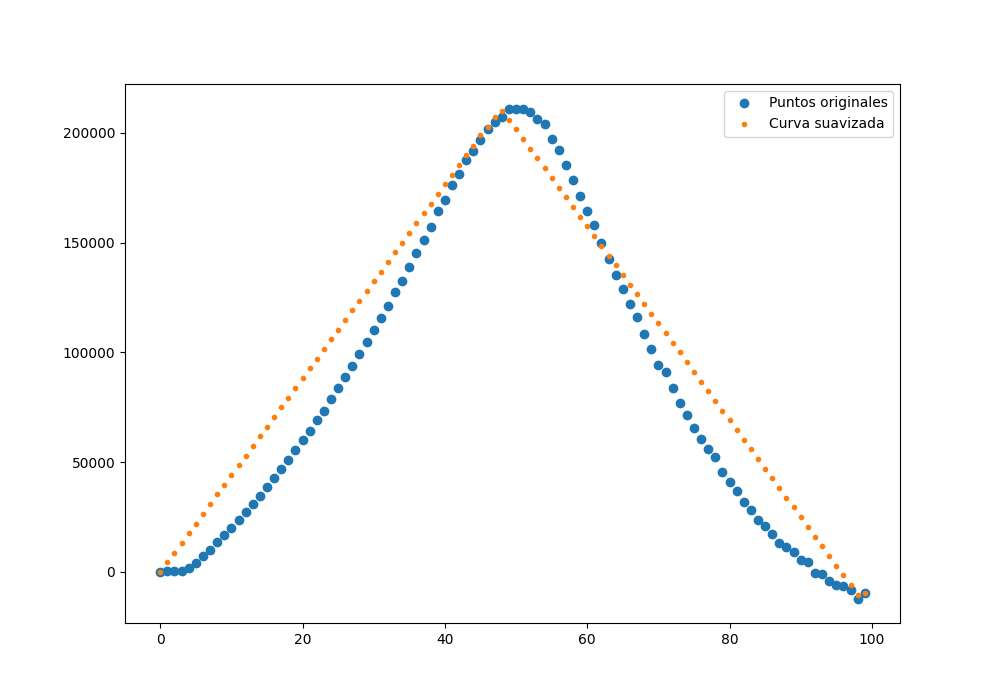

In [30]:
fig = plt.figure(figsize=(10, 7))

plt.plot( alt_pred-R0, 'o', label='Puntos originales')
plt.plot( alt, '.', label='Curva suavizada')
# ax.set_xlabel('Latitud')
# ax.set_ylabel('Longitud')
# plt.set_zlabel('Altura')
plt.legend()
# plt.tight_layout()
plt.show()